In [1]:
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt
import numpy as np




In [2]:
def fun_total(x, x_elastic, A_elastic, res, mu,\
              A_s, Delta, Gamma, T,\
              x_phonon1, A_phonon1, res_phonon1,\
                x_phonon2, A_phonon2, res_phonon2,\
                    x_background, A_background, res_background):
    y_elastic = fun_pvoigt(x, x_elastic, A_elastic, res, mu)
    y_s = fun_s(x, A_s, Delta, Gamma, T)
    y_phonon1 = fun_pvoigt(x, x_phonon1, A_phonon1, res_phonon1, mu)
    y_phonon2 = fun_pvoigt(x, x_phonon2, A_phonon2, res_phonon2, mu)
    y_background = fun_pvoigt(x, x_background, A_background, res_background, mu)
    return y_elastic + y_s + y_phonon1 + y_phonon2 + y_background

    

def fun_s(x, A, Delta, Gamma, T):
    def chi(q, omega, q_cdw, Delta, Gamma):
        c = 300
        temp = 1 / (Delta**2 + c**2 * (q - q_cdw)**2 - (omega + 1j*Gamma)**2)
        norm = 1/2 * 1 / np.sqrt(Delta**2 + c**2 * (q - q_cdw)**2)
        return temp * norm

    def S(q_array, Omega_array, q_cdw, Delta, Gamma, T):
        if np.isscalar(q_array):
            chi_array = chi(q_array, Omega_array, q_cdw, Delta, Gamma)
            return 1000 * 2 / (1 - np.exp(-Omega_array/T)) * np.imag(chi_array)
        else:
            q_mesh, Omega_mesh = np.meshgrid(q_array, Omega_array)
            chi_mesh = chi(q_mesh, Omega_mesh, q_cdw, Delta, Gamma)
            return 1000 * 2 / (1 - np.exp(-Omega_mesh/T)) * np.imag(chi_mesh)

    return A * S(0.235, x, 0.235, Delta, Gamma, T)

def fun_loren(x, x0, A, res):
    return A * (res/2)**2 / ((x - x0)**2 + (res/2)**2)

def fun_gauss(x, x0, A, res):
    k = res / 2
    sigma = k / (np.sqrt(2) * np.sqrt(np.log(2)))
    return A * np.exp(-(x - x0)**2 / (2 * sigma**2))

def fun_pvoigt(x, x0, A, res, mu):
    return mu * fun_loren(x, x0, A, res) + (1 - mu) * fun_gauss(x, x0, A, res)


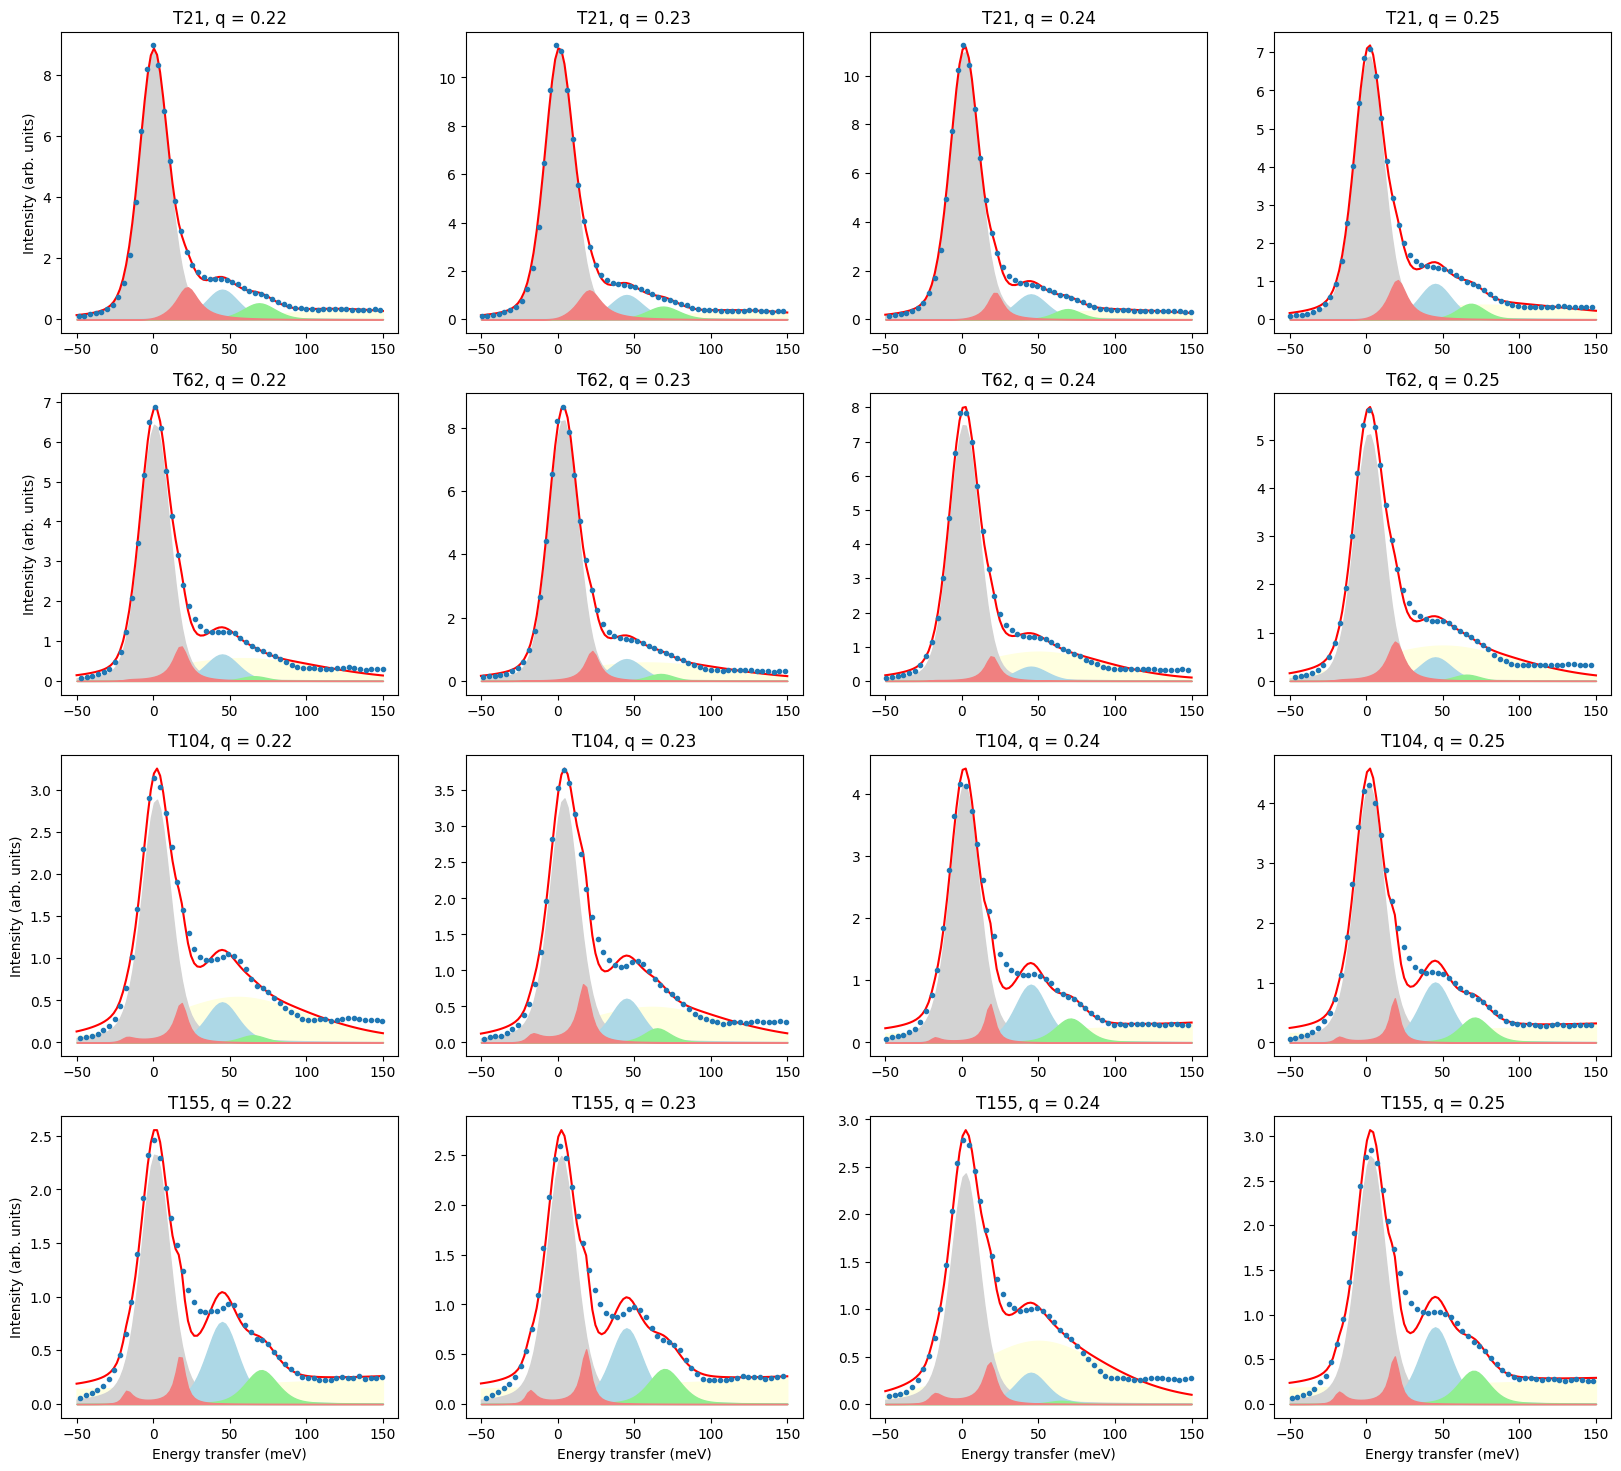

In [6]:
# Ttemp
temperatures_char = ['T21', 'T62', 'T104', 'T155']
temperatures = np.array([21, 62, 104, 155])*0.086
As = [54.9653,   48.9124,   37.0336,   22.8117]
mus = [0.3,0.22,0.4,0.4]
qs = np.array([0.05, 0.1, 0.15, 0.18, 0.2, 0.22, 0.23, 0.24, 0.25, 0.26, 0.27, 0.28, 0.287])
num = np.size(qs)
deltas = dict(T21= np.zeros(np.size(qs)), T62= np.zeros(np.size(qs)), T104= np.zeros(np.size(qs)), T155= np.zeros(np.size(qs)))
gammas = dict(T21= np.zeros(np.size(qs)), T62= np.zeros(np.size(qs)), T104= np.zeros(np.size(qs)), T155= np.zeros(np.size(qs)))
As = dict(T21= np.zeros(np.size(qs)), T62= np.zeros(np.size(qs)), T104= np.zeros(np.size(qs)), T155= np.zeros(np.size(qs)))
deltas_error = dict(T21= np.zeros(np.size(qs)), T62= np.zeros(np.size(qs)), T104= np.zeros(np.size(qs)), T155= np.zeros(np.size(qs)))
gammas_error = dict(T21= np.zeros(np.size(qs)), T62= np.zeros(np.size(qs)), T104= np.zeros(np.size(qs)), T155= np.zeros(np.size(qs)))
As_error = dict(T21= np.zeros(np.size(qs)), T62= np.zeros(np.size(qs)), T104= np.zeros(np.size(qs)), T155= np.zeros(np.size(qs)))


fig, axes = plt.subplots(4,4 , figsize=(20, 18))


for i,temperature in enumerate(temperatures_char):
    Ttemp = np.genfromtxt((temperature+'.csv'), delimiter=',')  
    Ttemp_sub = np.ones(np.shape(Ttemp))*1000

    for j,q in enumerate(qs):
        # subtract the elastic peak
        if j != 5 and j != 6 and j!=7 and j!=8:
            continue
        x_min = -50
        x_max = 5
        x = Ttemp[:,2*j]
        y = Ttemp[:,2*j+1]
        y = y[(x>x_min) & (x<x_max)]
        x = x[(x>x_min) & (x<x_max)]
        # Fit the data with the Voigt profile
        popt, pcov = curve_fit(fun_pvoigt, x, y , p0=[0, 10, 10, 10])
        # Extracting the parameters
        x0, A, fG, fL = popt
        Ttemp_sub[:,2*j] = Ttemp[:,2*j]
        Ttemp_sub[:,2*j+1] = Ttemp[:,2*j+1] - fun_pvoigt(Ttemp[:,2*j], *popt)
    
        # fit the data with fun_total

        x_min = -50
        x_max = 150
        x = Ttemp[:,2*j]
        y = Ttemp_sub[:,2*j+1]
        y = y[(x>x_min) & (x<x_max)]
        x = x[(x>x_min) & (x<x_max)]
        # x, x_elastic, A_elastic, res, mu,\
        #               A_s, Delta, Gamma, T,\
        #               x_phonon1, A_phonon1, res_phonon1\
        #               x_phonon2, A_phonon2, res_phonon2\
        #               x_background, A_background, res_background
        epsilon = 0.001
        parameters_guess = [0, 0, 22.5, mus[i],\
                            3, 20, 20, temperatures[i] ,\
                            50, 1, 22.5,\
                            80, 3, 22.5,\
                            150, 0.1, 200]
        lower_bounds = [-5, 0-epsilon, 22.5-epsilon, mus[i]-epsilon,\
                            0, 0, 0, temperatures[i]-epsilon ,\
                            30, 0, 20,\
                            50, 0, 20,\
                            50, 0, 80]
        upper_bounds = [5, 0, 22.5, mus[i],\
                            30, 100, 100, temperatures[i] ,\
                            70, 10, 50,\
                            110, 10,50,\
                            1000, 10, 1000]
        popt, pcov = curve_fit(fun_total, x, y , p0=parameters_guess,
                            bounds=(lower_bounds, upper_bounds))
        if pcov is not None:
            perr = np.sqrt(np.diag(pcov))
        else:
            perr = np.zeros_like(popt)
        
        deltas_error[temperature][j] = perr[5]
        gammas_error[temperature][j] = perr[6]
        As_error[temperature][j] = perr[4]

        deltas[temperature][j] = popt[5]
        gammas[temperature][j] = popt[6]
        As[temperature][j] = popt[4]

        # fit the data with elastic signal with fun_total
        x_min = -50
        x_max = 150
        x = Ttemp[:,2*j]
        y = Ttemp[:,2*j+1]
        y = y[(x>x_min) & (x<x_max)]
        x = x[(x>x_min) & (x<x_max)]
        # x, x_elastic, A_elastic, res, mu,\
        #               A_s, Delta, Gamma, T,\
        #               x_phonon1, A_phonon1, res_phonon1\
        #               x_phonon2, A_phonon2, res_phonon2\
        #               x_background, A_background, res_background
        epsilon = 0.001
        parameters_guess = [0, 10, 22.5, mus[i],\
                            As[temperature][j], deltas[temperature][j], gammas[temperature][j], temperatures[i] ,\
                            50, 1, 22.5,\
                            80, 3, 22.5,\
                            150, 0.1, 200]
        lower_bounds = [-10, 0, 22.5-epsilon, mus[i]-epsilon,\
                            As[temperature][j]-epsilon, deltas[temperature][j]*0.7, gammas[temperature][j]*0.7, temperatures[i]-epsilon ,\
                            45, 0, 20,\
                            65, 0, 20,\
                            50, 0, 80]
        upper_bounds = [10, 100, 22.5, mus[i],\
                            As[temperature][j], deltas[temperature][j]*1.3, gammas[temperature][j]*1.3, temperatures[i] ,\
                            65, 10, 25,\
                            110, 10,25,\
                            1000, 10, 1000]
        popt, pcov = curve_fit(fun_total, x, y , p0=parameters_guess,
                            bounds=(lower_bounds, upper_bounds))  
         
        deltas[temperature][j] = popt[5]
        gammas[temperature][j] = popt[6]
        As[temperature][j] = popt[4]
        # plot the result
        if j == 5 or j == 6 or j==7 or j==8:
            x_plot = np.linspace(-50, 150, 100)
            ax = axes[i,j-5]
            ax.plot(x_plot, fun_total(x_plot, *popt), 'r-', label='fit') 
            # plot shaded curve
            ax.fill_between(x_plot, fun_pvoigt(x_plot, popt[14], popt[15], popt[16], popt[3]), color='lightyellow') 
            ax.fill_between(x_plot, fun_pvoigt(x_plot, popt[0], popt[1], popt[2], popt[3]), color='lightgrey')
            ax.fill_between(x_plot, fun_pvoigt(x_plot, popt[8], popt[9], popt[10], popt[3]), color='lightblue')
            ax.fill_between(x_plot, fun_pvoigt(x_plot, popt[11], popt[12], popt[13], popt[3]), color='lightgreen')  
            # plot fun_s, shaded curve
            ax.fill_between(x_plot, fun_s(x_plot, popt[4], popt[5], popt[6], popt[7]), color='lightcoral') 
            # plot background, shaded curve
            ax.plot(x, y, '.', label='data')
            if j == 5:  # Only for the left-most column
                ax.set_ylabel('Intensity (arb. units)')
            if i == 3:  # Only for the bottom row
                ax.set_xlabel('Energy transfer (meV)')
            # create labels
            ax.set_title(temperatures_char[i]+', q = '+str(qs[j]))

# save figure as png
plt.savefig('lesco_method2_fitting.png', dpi=100, bbox_inches='tight')

    

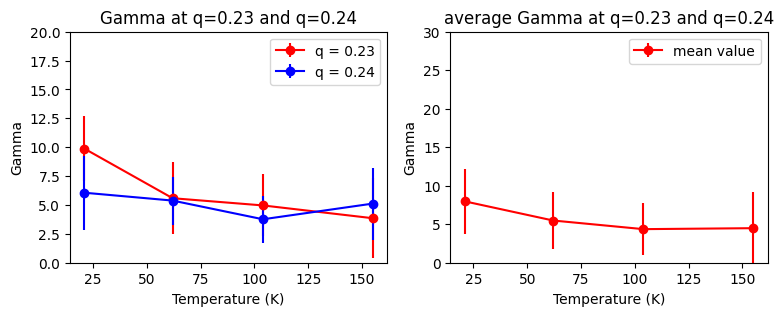

In [32]:
# Select the gammas at q=0.23 and q=0.24
gamma_q023 = np.array([gammas['T21'][6], gammas['T62'][6], gammas['T104'][6], gammas['T155'][6]])
gamma_q024 = np.array([gammas['T21'][7], gammas['T62'][7], gammas['T104'][7], gammas['T155'][7]])

# Select the error bars at q=0.23 and q=0.24
gamma_q023_error = np.array([gammas_error['T21'][6], gammas_error['T62'][6], gammas_error['T104'][6], gammas_error['T155'][6]])
gamma_q024_error = np.array([gammas_error['T21'][7], gammas_error['T62'][7], gammas_error['T104'][7], gammas_error['T155'][7]])

# Plot the gammas as a function of temperature with error bars
fig, axes = plt.subplots(1,2,figsize=(9, 3))
ax = axes[0]
ax.errorbar(temperatures/0.086, gamma_q023, yerr=gamma_q023_error, fmt='ro-', label='q = 0.23')
ax.errorbar(temperatures/0.086, gamma_q024, yerr=gamma_q024_error, fmt='bo-', label='q = 0.24')
ax.set_xlabel('Temperature (K)')
ax.set_ylabel('Gamma')
ax.legend()
ax.set_title('Gamma at q=0.23 and q=0.24')
ax.set_ylim([0, 20])
ax = axes[1]
ax.errorbar(temperatures/0.086, (gamma_q023+gamma_q024)/2, yerr=np.sqrt(gamma_q023_error**2+gamma_q024_error**2), fmt='ro-', label='mean value')
ax.set_xlabel('Temperature (K)')
ax.set_ylabel('Gamma')
ax.legend()
ax.set_title('average Gamma at q=0.23 and q=0.24')
ax.set_ylim([0, 30])
fig.savefig('lesco_method2_gamma.png', dpi=100, bbox_inches='tight')


In [15]:
np.array(gamma_q023)

array([9.87494363, 5.58497222, 4.96009012, 3.85433674])

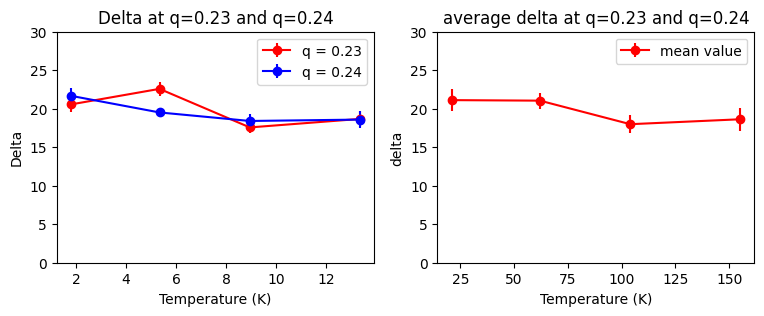

In [31]:
# Select the deltas at q=0.23 and q=0.24
delta_q023 = np.array([deltas['T21'][6], deltas['T62'][6], deltas['T104'][6], deltas['T155'][6]])
delta_q024 = np.array([deltas['T21'][7], deltas['T62'][7], deltas['T104'][7], deltas['T155'][7]])

# Select the error bars at q=0.23 and q=0.24
delta_q023_error = np.array([deltas_error['T21'][6], deltas_error['T62'][6], deltas_error['T104'][6], deltas_error['T155'][6]])
delta_q024_error = np.array([deltas_error['T21'][7], deltas_error['T62'][7], deltas_error['T104'][7], deltas_error['T155'][7]])

# Plot the deltas as a function of temperature with error bars
fig, axes = plt.subplots(1,2,figsize=(9, 3))
ax = axes[0]
ax.errorbar(temperatures, delta_q023, yerr=delta_q023_error, fmt='ro-', label='q = 0.23')
ax.errorbar(temperatures, delta_q024, yerr=delta_q024_error, fmt='bo-', label='q = 0.24')
ax.set_xlabel('Temperature (K)')
ax.set_ylabel('Delta')
ax.legend()
ax.set_title('Delta at q=0.23 and q=0.24')
ax.set_ylim([0, 30])

ax = axes[1]
ax.errorbar(temperatures/0.086, (delta_q023+delta_q024)/2, yerr=np.sqrt(delta_q023_error**2+delta_q024_error**2), fmt='ro-', label='mean value')
ax.set_xlabel('Temperature (K)')
ax.set_ylabel('delta')
ax.legend()
ax.set_title('average delta at q=0.23 and q=0.24')
ax.set_ylim([0, 30])

fig.savefig('lesco_method2_delta.png', dpi=100, bbox_inches='tight')
plt.show()


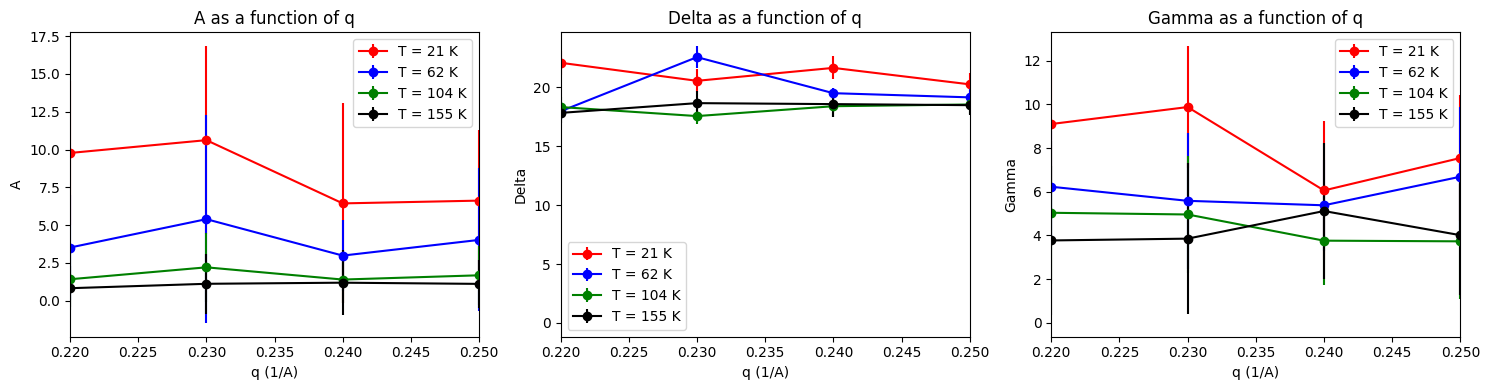

In [7]:
# plot As, deltas, gammas, as a function of q with error bars
fig, ax = plt.subplots(1, 3, figsize=(15, 4))

# Plot As
ax[0].errorbar(qs, As['T21'], yerr=As_error['T21'], fmt='ro-', label='T = 21 K')
ax[0].errorbar(qs, As['T62'], yerr=As_error['T62'], fmt='bo-', label='T = 62 K')
ax[0].errorbar(qs, As['T104'], yerr=As_error['T104'], fmt='go-', label='T = 104 K')
ax[0].errorbar(qs, As['T155'], yerr=As_error['T155'], fmt='ko-', label='T = 155 K')
ax[0].set_xlabel('q (1/A)')
ax[0].set_ylabel('A')
ax[0].set_xlim(0.22, 0.25)
ax[0].legend()
ax[0].set_title('A as a function of q')

# Plot deltas
ax[1].errorbar(qs, deltas['T21'], yerr=deltas_error['T21'], fmt='ro-', label='T = 21 K')
ax[1].errorbar(qs, deltas['T62'], yerr=deltas_error['T62'], fmt='bo-', label='T = 62 K')
ax[1].errorbar(qs, deltas['T104'], yerr=deltas_error['T104'], fmt='go-', label='T = 104 K')
ax[1].errorbar(qs, deltas['T155'], yerr=deltas_error['T155'], fmt='ko-', label='T = 155 K')
ax[1].set_xlabel('q (1/A)')
ax[1].set_ylabel('Delta')
ax[1].set_xlim(0.22, 0.25)
ax[1].legend()
ax[1].set_title('Delta as a function of q')

# Plot gammas
ax[2].errorbar(qs, gammas['T21'], yerr=gammas_error['T21'], fmt='ro-', label='T = 21 K')
ax[2].errorbar(qs, gammas['T62'], yerr=gammas_error['T62'], fmt='bo-', label='T = 62 K')
ax[2].errorbar(qs, gammas['T104'], yerr=gammas_error['T104'], fmt='go-', label='T = 104 K')
ax[2].errorbar(qs, gammas['T155'], yerr=gammas_error['T155'], fmt='ko-', label='T = 155 K')
ax[2].set_xlabel('q (1/A)')
ax[2].set_ylabel('Gamma')
ax[2].set_xlim(0.22, 0.25)
ax[2].legend()
ax[2].set_title('Gamma as a function of q')

plt.tight_layout()
plt.show()

